# Automated text classifier and named entity extractor
**Renier Alexander van Staden**

## External Libraries 

In [113]:
# Pandas
import pandas as pd

# Sklearn
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

# NLTK
import nltk
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
#nltk.download()

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import fuzzywuzzy
from fuzzywuzzy import fuzz


print('The pandas version is {}.'.format(pd.__version__))
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The pandas version is 0.25.1.
The nltk version is 3.4.5.
The scikit-learn version is 0.21.3.


## Preprocessing and Data Wrangling

### Article Data

In [4]:
# Load cleaned csv file
articles_df = pd.read_csv("abc_articles_df.csv", sep='|', encoding='utf-16')
articles_df.head()

,uri,article_category,article_text,description
0,/news/2021-11-24/afl-carlton-ceo-brian-cook-te...,sport,Carlton chief executive Brian Cook has tested...,Carlton AFL boss returns positive COVID test
1,/news/2021-11-24/afl-national-draft-kangaroos-...,sport,Outstanding South Australian prospect Jason H...,Kangaroos take Horne-Francis with number one s...
2,/news/2021-11-24/shaun-murphy-amateurs-not-pla...,sport,Professional snooker player Shaun Murphy says...,Former champion says amateur snooker players s...
3,/news/2021-11-24/teen-star-sophie-dwyer-headli...,sport,Giants goal-attack Sophie Dwyer has been elev...,Rising star Sophie Dwyer earns call-up to Aust...
4,/news/2021-11-24/wbbl-brisbane-heat-vs-adelaid...,sport,Adelaide Strikers spinner Amanda-Jade Welling...,Adelaide Strikers stay alive in WBBL finals wi...


The following preprocessing tasks are performed:
- Drop all rows with any NA's
- Combine article text and description fields to create 'corpus document'. A copy of this is also created for further processing as a 'bag of words'.
- Drop any unnecessary columns.
- Show statistics

In [5]:
# Combine columns and drop uncessary columns

# Drop NA's
articles_df.dropna(inplace=True) 

# Combine text and description into 1 column
articles_df['article_text_description'] = articles_df['article_text'].fillna('') + articles_df['description'].fillna('')

# Drop unnecesarry columns
articles_df.drop(columns=['description','article_text'], inplace=True) 

# Bag of words for further processing later
articles_df['bag_of_words'] = articles_df['article_text_description'] 


# Show counts and description
articles_df.groupby(['article_category']).count()


,uri,article_text_description,bag_of_words
article_category,,,
business,112,112,112
sport,124,124,124


Dropping of NA's has reduced the corpus size from 243 articles down to 228. Article Categories are still in balance.


The helper function below assists with cleaning up Unicode issues that have arisen as part of data wrangling.

In [6]:
# Fix unicode issues
def fix_unicode_issues(df):  
    df['article_text_description'] = df['article_text_description'].replace(u'â€”', u' ')
    df['article_text_description'] = df['article_text_description'].replace(u'â€“', u' ')  
    
    return df

articles_df = articles_df.apply(fix_unicode_issues, axis=1)

### ASX Data

In [95]:
# Import ASX data
asx_df = pd.read_csv('ASX_Listed_Companies_04-12-2021_05-22-49_AEDT.csv')

asx_df.head()

,ASX code,Company name,Listing date,GICs industry group,Market Cap
0,14D,1414 DEGREES LIMITED,2018-09-12,Capital Goods,23064453.0
1,1AD,ADALTA LIMITED,2016-08-22,"Pharmaceuticals, Biotechnology & Life Sciences",19651595.0
2,1AG,ALTERRA LIMITED,2008-05-16,"Food, Beverage & Tobacco",8333288.0
3,1ST,1ST GROUP LIMITED,2015-06-09,Health Care Equipment & Services,6549087.0
4,1VG,VICTORY GOLDFIELDS LIMITED,2021-07-22,Materials,9406886.0


## NLP Task 1 - Article Classification

NLP Task 1 will be a classification machine learning task to classify articles between sport and business classes. This task consists of the following steps:

**Step 1: Embedding - create a 'bag of words' and process words**

'Bag of words' (Harris, 1954) is a representation of of a body of text that only considers the words in the text, not the sentence structure, grammar or relationships between them. According to [Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model) it is often used in text classification.

Word processing will include:
- Each documents punctuation and numerical is removed and all words are converted to lower case.
- All stopwords are removed.
- All words are lemmatized.
- All words are stemmed.

**Step 2: Feature Extraction - Encoding and TF-IDF**

According to Ullman & Rajaraman (Ullman & Rajaraman, 2012) TF-IDF is "The formal measure of how concentrated into relatively few documents are the occurrences of a given word is called TF.IDF (Term Frequency times Inverse Document Frequency)."

**Step 3: Model selection, evaluation and measurement**

The selected model for the classification task is Random Forest. It is selected because:
- Random Forest Model's are less prone to overfitting
- Tree based models are better for explainability and interpretability.
- Random Forest is selected over other tree models because it ensures decorrelation between variables. This is important as some words in the 'bag of words' may be correlated across different classes.



In [14]:
# Stemming, Lemmatizing and Cleaning Bag of Words

def nltk_remove_punc_numeric(df_column):
    # Function to remove punctuation and numeric values from bag of words column
    df_column = df_column.split(' ')
    output=[word.lower() for word in df_column if word.isalpha()]
    return ' '.join(output)  
    
def nltk_stemming(df_column):
    # Function to stem words in bag of words column
    df_column = df_column.split(' ')
    stemmer = PorterStemmer() 
    output = [stemmer.stem(word) for word in df_column]
    return ' '.join(output) 

def nltk_lemmatize(df_column):
    # Function to lemmatize words in bag of words column
    df_column = df_column.split(' ')
    lemmatizer = WordNetLemmatizer()
    output = [lemmatizer.lemmatize(word) for word in df_column]
    return ' '.join(output) 
            
def nltk_remove_stopwords(df_column):
    # Function to remove stopwords from bag of words column
    df_column = df_column.split(' ')
    stopWords = set(stopwords.words('english'))
    output=[word.lower() for word in df_column if not word in stopWords]
    return ' '.join(output)  

def run_all_nltk_cleaning(df):    
    # Function to run all NLTK cleaning
    df_prepped = df
    print('Removing Punctuation and Numbers...')
    df_prepped['bag_of_words'] = df['bag_of_words'].apply(nltk_remove_punc_numeric)
    print('Removing Stopwords...')
    df_prepped['bag_of_words'] = df['bag_of_words'].apply(nltk_remove_stopwords)
    print('Applying Lemmatizing...')
    df_prepped['bag_of_words'] = df['bag_of_words'].apply(nltk_lemmatize)
    print('Applying Stemming...')
    df_prepped['bag_of_words'] = df['bag_of_words'].apply(nltk_stemming)
    
    return df_prepped

articles_df  = run_all_nltk_cleaning(articles_df)
articles_df.head(10)

Removing Punctuation and Numbers...
Removing Stopwords...
Applying Lemmatizing...
Applying Stemming...


,uri,article_category,article_text_description,bag_of_words
0,/news/2021-11-24/afl-carlton-ceo-brian-cook-te...,sport,Carlton chief executive Brian Cook has tested...,carlton chief execut brian cook test posit for...
1,/news/2021-11-24/afl-national-draft-kangaroos-...,sport,Outstanding South Australian prospect Jason H...,outstand south australian prospect jason selec...
2,/news/2021-11-24/shaun-murphy-amateurs-not-pla...,sport,Professional snooker player Shaun Murphy says...,profession snooker player shaun murphi say ama...
3,/news/2021-11-24/teen-star-sophie-dwyer-headli...,sport,Giants goal-attack Sophie Dwyer has been elev...,giant sophi dwyer elev diamond tour invite sen...
4,/news/2021-11-24/wbbl-brisbane-heat-vs-adelaid...,sport,Adelaide Strikers spinner Amanda-Jade Welling...,adelaid striker spinner wellington produc best...
5,/news/2021-11-25/23-under-23-a-league-women-pl...,sport,Australia's top professional women's competit...,top profession competit long greenhous produc ...
6,/news/2021-11-25/a-league-women-lisa-de-vanna-...,sport,Matildas great Lisa De Vanna will chase anoth...,matilda great lisa de vanna chase anoth titl s...
7,/news/2021-11-25/afl-draft-live-blog-second-ro...,sport,Fremantle wasted no time claiming Matt Johnso...,fremantl wast time claim matt johnson kick sec...
8,/news/2021-11-25/australians-josh-giddey-patty...,sport,Young Australian Josh Giddey has again flirte...,young australian josh giddey flirt creat nba b...
9,/news/2021-11-25/candice-warner-weighs-in-on-t...,sport,"Candice Warner says she is ""concerned"" about ...",candic warner say cricket stanc allow tim pain...


In [17]:
# Show example Bag of Words
print(articles_df['bag_of_words'].head(1).values)

['carlton chief execut brian cook test posit forc key staff member miss afl nation draft fulli vaccin cook isol home next day per victorian govern posit test mean recruit team includ head coach michael voss footbal manag brad lloyd attend first night identifi close blue releas statement say afl player instruct get test home receiv neg main concern health safeti sincer appreci get test afternoon short cook said feel evid import peopl aflw program impact clear continu preseason join club follow success career chief execut essendon counterpart xavier campbel test posit last weekcarlton afl bo return posit covid test']


Below is an example of the result of the word processing above:

>*carlton chief execut brian cook test posit forc key staff member miss afl nation draft fulli vaccin cook isol home next day per victorian govern posit test mean recruit team includ head coach michael voss footbal manag brad lloyd attend first night identifi close blue releas statement say afl player instruct get test home receiv neg main concern health safeti sincer appreci get test afternoon short cook said feel evid import peopl aflw program impact clear continu preseason join club follow success career chief execut essendon counterpart xavier campbel test posit last weekcarlton afl bo return posit covid test*

All punctuation and capitalisation has been removed. Stopword remove has removed words like "has". Lemmatizing has changed words to their root for - for example (from the text): "tested" to "test". Stemming has taken this another step further by removing certatin work ending.

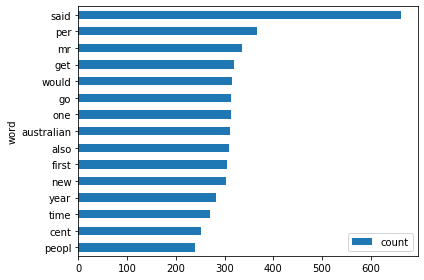

In [37]:
## Creating FreqDist for 15 most frequent words in bag of words 

# Count vectorizer
count_vec = CountVectorizer() 

# Function to plot words
def freq_words(x, vectorizer, terms = 30, filename=None): 
  
    X = vectorizer.fit_transform(x)
    X_label = vectorizer.get_feature_names() # Get words
    X_array = X.toarray() # Convert to array
    words_zipped_count = list(zip(
            X_label, np.sum(X_array,axis=0).tolist())) # Combine works with sum of works across docs
    words_count_df = pd.DataFrame(words_zipped_count, columns=['word', 'count']) # Create dataframe
    words_count_df = words_count_df.sort_values(
            by='count', ascending=False) # Sort with most frequent words first


    # selecting top n most frequent words 
    d1 = words_count_df.nlargest(columns="count", n = terms).sort_values(by=['count'],ascending=True)
    

    # visualize words and frequencies

    d1.plot(kind='barh', x='word', y='count') #, y='word'
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

freq_words(articles_df['bag_of_words'], count_vec, 15)


The chart above shows the top 15 words  by frequency across the corpus.

## Encode Categorical Target Variable for Classification

The classification is set up as a binary classification problem. The two classes ('business' and 'sport') will encoded in binary format using Sklearn's LabelBinarizer. The results of this is that 'sport' is set to 1 and 'business' is set to 0. This is important because most machine learning models require a numerical, vector representation of words for model training. 

The limitation of setting up this as a binary classification problem is that if another class (for example, 'food') is introduced the model would require updating. To solve this, classes could be encoded using "One Hot Encoding", which would encode each class using it's own binary encoding. 

In [40]:
# Encode 2 classes from 'Article Category' as Binary encoding
articles_df['article_category'].astype('category')

lb = preprocessing.LabelBinarizer() # Create binarizer

# Fit binarizer to category variable, transfrom variable and store to new variable
articles_df['article_category_bin'] = lb.fit_transform(articles_df['article_category'])

articles_df.head()


,uri,article_category,article_text_description,bag_of_words,article_category_bin
0,/news/2021-11-24/afl-carlton-ceo-brian-cook-te...,sport,Carlton chief executive Brian Cook has tested...,carlton chief execut brian cook test posit for...,1
1,/news/2021-11-24/afl-national-draft-kangaroos-...,sport,Outstanding South Australian prospect Jason H...,outstand south australian prospect jason selec...,1
2,/news/2021-11-24/shaun-murphy-amateurs-not-pla...,sport,Professional snooker player Shaun Murphy says...,profession snooker player shaun murphi say ama...,1
3,/news/2021-11-24/teen-star-sophie-dwyer-headli...,sport,Giants goal-attack Sophie Dwyer has been elev...,giant sophi dwyer elev diamond tour invite sen...,1
4,/news/2021-11-24/wbbl-brisbane-heat-vs-adelaid...,sport,Adelaide Strikers spinner Amanda-Jade Welling...,adelaid striker spinner wellington produc best...,1


## Create Feature Vector

A feature vector for each document will be created using Sklearn's TfidfVectorizer. Through trail and error (using best performance of accuracy using 5 fold cross validation) of hyperparamaters the following hyperparamters for the vectorizer where found to work best with the Random Forest Model:

* NGram was set to include 1 and 2 word grams.
* Max Features is set to 1000. That means only the top 1000 TF-IDF words/ngrams are used, not all words/ngrams. 

In [48]:
# TF-IDF

# Create TF-IDF vectorizer
tfidf_vec = TfidfVectorizer(max_features=1000, ngram_range=(1, 2)) 

# Fit and transform to 'bag of words' and convert to nd.array 
X = tfidf_vec.fit_transform(articles_df['bag_of_words']).toarray() 

print(X.shape) 

#Create target variable as nd.array
y = articles_df['article_category_bin'].values 


print(y.shape)


(236, 1000)
(236,)


**Most frequent words (using TF-IDF) for 'sport' class:**

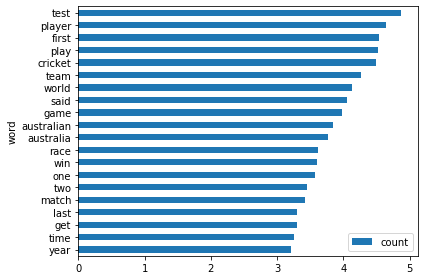

In [50]:
freq_words(articles_df['bag_of_words'][articles_df['article_category_bin']==1], tfidf_vec, 20)

**Most frequent words (using TF-IDF) for 'business' class:**

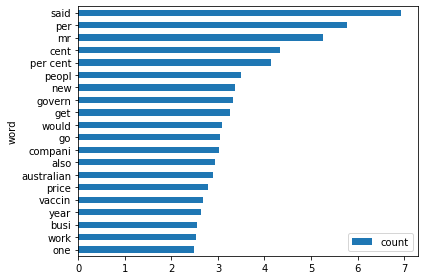

In [51]:
freq_words(articles_df['bag_of_words'][articles_df['article_category_bin']==0], tfidf_vec, 20)

## Training Test Split

The corpus will be split into 10% for testing and 90% for training. 

In [54]:
# Split population in test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 0)


## Model

### Training

#### Random Forest Model

The following explict and implicit hyperparameters were selected for the Random Forest model. They were selected through a combination of trail and error (using best performance of accuracy using 5 fold cross validation) as the measure and literature guidance.

* Number of estimators set to 100 based on trial and error. Other values attempted were (10, 50, 200, 1000, 10000). 
* Max depth set to None, which implies leaved are pruned until they are pure ([Sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). This was set using trial and error. Other values attempted were (1, 2). Literature recommends p/3.
* All other parameters were kept at SKlean's default values.

Limitations of this approach are that these hyperparameters might not be the globally optimal parameters. This could be improved using gridsearch.



In [56]:
#Create a Random Forest Model
classifier_rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the model using the training sets
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### Guassian Naive Bayes Model

A Naive Bayes model was also training to compare the Random Forest to. Naive Bayes are often used in text classification problems.

In [57]:
#Create a Gaussian Classifier
classifier_nb = GaussianNB()

# Train the model using the training sets
classifier_nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

### Evaluation

Models will be evaulated using 5 fold cross validation of the training set to ensure all data is used. Accuracy will be used as the measure, including the standard deviation of accuracy to ensure the model is stable.

#### Random Forest Model

In [59]:
# Perform 5 fold cross validation
fold_accuracies = cross_val_score(estimator = classifier_rf, X = X_train, y = y_train, cv = 5)

# 5 fold cross validation results
print('Random Forest Model')
print("Accuracy: {:.2f}%".format(fold_accuracies.mean()*100))
print("Standard Deviation: {:.2f}%".format(fold_accuracies.std()*100))

Random Forest Model
Accuracy: 95.24%
Standard Deviation: 3.42%


#### Guassian Naive Bayes Model

In [60]:
# Perform 5 fold cross validation
fold_accuracies = cross_val_score(estimator = classifier_nb, X = X_train, y = y_train, cv = 5)

# 5 fold cross validation results
print('Naive Bayes')
print("Accuracy: {:.2f}%".format(fold_accuracies.mean()*100))
print("Standard Deviation: {:.2f}%".format(fold_accuracies.std()*100))

Naive Bayes
Accuracy: 91.94%
Standard Deviation: 4.18%


Results:

|Measure|Random Forest|Naive Bayes|
|:---|---|---|
|Accuracy|95.24%|3.42%|
|Standard Deviation of Accuracy|95.24%|4.18%|


From the table above it can be seen than the Random forest produces a higher accuracy and has a lower standard deviation. It will be used for classification.

### Random Forest Performance On Test Data

In [78]:
# Measure performance against test set
y_pred = classifier_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', cm)
print("\nAccuracy: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))


Confusion Matrix: 
 [[ 9  0]
 [ 0 15]]

Accuracy: 100.00%


Performance on the hold out test data is very good; 100% accuracy!

# NLP Task 2


NLP Task 2's objective is to extract company names from business articles. NLP Task 2 can be broken down into the following steps:

**Step 1 - Filter to only include business articles**
This task only applies to business articles, because it is only businesses listed on the stock exchange.

**Step 2 - Extract parts of speech from documents**
Parts of speech will be extracted and tagged with various functions from the NLTK library.

**Step 3 - Extract potential named entities using chunking**
Chucking will be performed to identify potential named entities using the NLTK library and Regex.

**Step 4 - Search for matches for the potential named entities in the ASX dataset.**

Instead of using standard or existing list of entity categories a custom algorithm will be used to search for similar coompany names in the ASX dataset. Cosine distance will be used as a similarity measure. The ASX will be prepocessed using a few basic NLP tasks and then vectorized.



In [87]:
# Filter business articles only
business_articles_df = articles_df[articles_df['article_category']=='business'].copy()

### Potential Named Entity Extraction

The 'bag of words' created earlier for Task 2 will not be used. The original article text will be used. The following processing is performed on each article text:

* Tokenize sentences in articles
* Tokenize words in sentences
* Using NLTK's 'pos_tag' function to tag all parts of speech ('pos').

Potential Named Entities are then extracted from the 'pos' using NLTK's Regex funtion with the follow paramaters:

* <NNP.?>+ - Identify at least 1 or more singular or plural proper nouns. All company names (among other things) are proper nouns.
* <NN.>* - These tags are included before and after the proper noun tags. They identify zero, one or more singular or plural non-proper nouns. Through experimentation this was found to work well in identifying most potential company names. While this does deviate from conventional grammar, company names often have more than one noun in them.


In [92]:
# Extract Potential Named Entities 
def get_potential_entities(df_row):
    
    # Input is a whole dataframe row. Expects 'article_text_description' variable to be present
    potential_entities = set() # Output variable
    document = df_row['article_text_description']
    
    # Get Parts of Speech using NLTK
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    sentences = [nltk.pos_tag(sentence) for sentence in sentences]
    
    # Chunking
    chunck_pos_regex = """NP: {<NN.>*<NNP.?>+<NN.>*}""" # Identify proper nouns 
    chunck_parser = nltk.RegexpParser(chunck_pos_regex) # Create Parser
    
    # Loop through each sentence in text, parse chunks in sentence and store into temp variable
    for sentence in sentences:
        result = chunck_parser.parse(sentence)
        
        # Filter for proper noun chunks only
        subtrees = result.subtrees(filter=lambda t: t.label() == 'NP')
        named_words = None
        for subtree in subtrees:        
            named_words = [word[0].lower() for word in subtree.leaves()]
            named_words = ' '.join(named_words)
        if named_words is not None: potential_entities.add(named_words)

    return list(potential_entities)


business_articles_df['potential_entities'] = business_articles_df.apply(get_potential_entities, axis=1)


In [205]:
# Example of potential entities
business_articles_df['potential_entities'].iloc[29]


['social housing future fund',
 'low-income',
 'grattan institute',
 'ahuri',
 'grattan',
 'commonwealth',
 'australia',
 'rent assistance',
 'michael janda',
 'investment corporation',
 'australians',
 'mr coates',
 'medicare']

Potential entity matches are added as a list to a new column in the 'business_articles_df'. The table above shows an example of the potential entities extracted from a single article.

### Further processing on ASX data

The following preprocessing was done on the ASX data set to prepare it for the cosine distance calculator:

* A custom stop word list was created to remove generic company name terms like 'limited'.
* All names were changed to lower case.

In [138]:
stopwords = ['limited','ltd','plc', 'group', 'australia','australian', '.']

def clean_text(df_row):
    word_list = str(df_row['Company name'])
    word_list = word_list.split(' ')
    #print(word_list)
    filtered_words = [str(word.lower()) for word in word_list if word.lower() not in stopwords]
    return ' '.join(filtered_words)
    
asx_df['name_clean'] = asx_df.apply(clean_text, axis=1)  

asx_df.head()

,ASX code,Company name,Listing date,GICs industry group,Market Cap,name_clean
0,14D,1414 DEGREES LIMITED,2018-09-12,Capital Goods,23064453.0,1414 degrees
1,1AD,ADALTA LIMITED,2016-08-22,"Pharmaceuticals, Biotechnology & Life Sciences",19651595.0,adalta
2,1AG,ALTERRA LIMITED,2008-05-16,"Food, Beverage & Tobacco",8333288.0,alterra
3,1ST,1ST GROUP LIMITED,2015-06-09,Health Care Equipment & Services,6549087.0,1st
4,1VG,VICTORY GOLDFIELDS LIMITED,2021-07-22,Materials,9406886.0,victory goldfields


The table above shows the original ASX data with the newly added 'name_clean' field, which contains the processed data.

### Model 

The corpus is all cleaned company names in the Asx data set. A document is either a company name in the list or the potential entity being searched for.

The model executes the following steps:

* Create labels and document term matrix for all documents in ASX corpus.
* Convert the potential entity text (new data) to a document term matrix using the ASX vectorizer. Because this is a one way match only this is done to ensure that only words already in ASX corpus are considered. This ensures that irrelevant words from invalid potential entities are not added to the corpus and then matched later.
* Calculate the cosine distance between each potential entity from each article and each document in the ASX corpus.
* Only return matches if the cosine distance is lower that 0.2. This threshold was set using trial and error.
* Create a output dataframe with all potential ASX matches.

The code section below shows the implementation of this.

In [ ]:
# Fix count vectorizer on ASX data
count_vec_asx = CountVectorizer()
fitted_count_vec_asx = count_vec_asx.fit(asx_df['name_clean'])
asx_doc_term_mat = count_vec_asx.transform(asx_df['name_clean'])


def find_potential_entity_in_asx(potential_entity, count_vec, asx_doc_term_mat):
    # for a given potential entity find similar documents in ASX corpus
    potential_entity_doc_term_mat = count_vec_asx.transform(potential_entity) #transform potential entity to dtm
    X = asx_doc_term_mat
    a1 = potential_entity_doc_term_mat.toarray()
    best = 0
    best_dist = 9999
 
    # Calculate cosine distance between potential_entity and each document in ASX corpus and return best match
    for i in range(X.shape[0]):
        a2 = X.getrow(i).toarray()[0]
        dist = cosine(a1, a2)
        if dist < best_dist:
            best_dist = dist
            best = i 

    best_match_index = None
    
    # Filter threshold - only return matches with a smaller distance that threshold
    if best_dist < 0.2:
        best_match_index = best
    
    return best_match_index, best_dist

def find_potential_match(business_articles_df, asx_df):
    # Function to iterate over all potential entities in each article and search for match in ASX data.
    
    #Create output dataframe
    match_df = pd.DataFrame(columns={'uri','potential_entities',
                                     'potenitial_asx_company_name', 'cosine_distance'})
    
    # Iterate over input dataframe rows (articles)
    for idx, df_row in business_articles_df.iterrows():
        
        print(df_row.name)
        output = None
        best_match_count = 0
        
        # Iterate through potential entities identified in row (article)
        for potential_entity in df_row['potential_entities']:
            best_match_index, best_dist = find_potential_entity_in_asx(
                    [potential_entity], count_vec_asx, asx_doc_term_mat)
            
            # If match is found append to output dataframe
            if best_match_index is not None:                
                best_match = asx_df['Company name'].iloc[best_match_index]
         
                match_df = match_df.append(pd.DataFrame(
                        data=[[df_row['uri'], potential_entity, best_match, best_dist]] ,
                        columns={'uri','potential_entities','potenitial_asx_company_name', 'cosine_distance'}),
                        ignore_index=True)

                
    return match_df


match_df = find_potential_match(business_articles_df, asx_df)
                


In [226]:
match_df.rename(columns={ 'cosine_distance':'uri',
                         'uri':'potenitial_asx_company_name', 'potenitial_asx_company_name':'cosine_distance' },
                inplace = True)



In [236]:
print('Number of Business Articles Evaulated: ', business_articles_df['uri'].count())
print('Number of Potential Entity Matches: ', match_df['uri'].count())
print('Number of unique Articles with at least 1 match: ', match_df['uri'].drop_duplicates().count())
print('Number of unique ASX companies matched: ' ,match_df['potenitial_asx_company_name'].drop_duplicates().count())
print('Cosine Statistics: \n', match_df['cosine_distance'].describe())
match_df.head()

Number of Business Articles Evaulated:  112
Number of Potential Entity Matches:  31
Number of unique Articles with at least 1 match:  19
Number of unique ASX companies matched:  20
Cosine Statistics: 
 count    31.000000
mean      0.029597
std       0.068608
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.183503
Name: cosine_distance, dtype: float64


,uri,potential_entities,potenitial_asx_company_name,cosine_distance
0,/news/2021-11-26/uranium-miner-vimy-mulga-rock...,vimy resources,VIMY RESOURCES LIMITED,0.000000
1,/news/2021-11-27/queensland-mining-towns-face-...,bhp,BHP GROUP LIMITED,0.000000
2,/news/2021-11-28/bobby-pate-kombi-coffee-van-b...,fleetwood mac,FLEETWOOD LIMITED,0.000000
3,/news/2021-11-28/community-rallies-against-woo...,bhp,BHP GROUP LIMITED,0.000000
4,/news/2021-11-29/markets-wall-street-dow-jones...,st george economists,ST GEORGE MINING LIMITED,0.183503


In [237]:
match_df.to_csv('match_df.csv')

### Evaluation

A total of 112 business articles were evaluated for potential entities. 31 potential entity matches in 19 of these articles. These potential matches identified 20 potential ASX companies. The cosine similarity measure had a mean of 0.03 and a standard deviation of 0.07, which means most matches were very good and reliable.

Due to the lack of ground truth data for this model and the low number of matches all matches were checked manually by a 'human in the loop'. 20 of the 31 matches were found to be accurate, which is an accuracy score of 65%. Below are some examples of correct matches:

|Named Entity from NLP|ASX company name from matching|
|:---|---|
|vimy resources|VIMY RESOURCES LIMITED|
|tassal|TASSAL GROUP LIMITED|
|endeavour group|ENDEAVOUR GROUP LIMITED|
|national australia bank|NATIONAL AUSTRALIA BANK LIMITED|

